### Importing the required libraries to wrangle & analyze the dataset(s):

In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import glob
import tweepy
import json
from tweepy import OAuthHandler
from timeit import default_timer as timer
import datetime
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# A) Gathering the data:
### Inputs:
1- `twitter-archive-enhanced.csv`

2- `https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'`

3- `Twitter API` (tweet_json.txt)

#### Gathering data files:
1- From a csv file: `twitter-archive-enhanced.csv`

In [440]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2- Programmatically from a URL: `image_predictions.tsv` & reading into `image_predictions_df`

In [441]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = 'image_predictions.tsv'
if not os.path.isfile(file_name):
    response = requests.get(url)
    with open(file_name, 'wb') as file:
        file.write(response.content)

In [442]:
image_predictions_df = pd.read_csv('image_predictions.tsv', '\t')

In [443]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3- Querying Twitter API: `tweet_json.txt` & reading into `api_df`

In [444]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [445]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)


2356

In [446]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
if not os.path.isfile('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
end = timer()
print(end - start)
print(fails_dict)

0.0005030210004406399
{}


In [447]:
# Using json library to read the `tweet_json.txt` file into api_df dataframe: 
cols = ['tweet_id','retweet_count','favorite_count']
api_df = pd.DataFrame(columns =cols)

file_name = 'tweet_json.txt'
with open(file_name, encoding= 'utf-8') as file:
    for line in file:
        data = json.loads(line)
        lst_dct = ({'tweet_id': data['id_str'],'retweet_count': data['retweet_count'],'favorite_count': data['favorite_count']})
        api_df = api_df.append(lst_dct, ignore_index = True)
    

In [448]:
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Gathering Output:
### 3 dataframes:
1- `archive_df`

2- `image_predictions_df`

3- `api_df`

# B) Assessing the data:

### Visual & Programmatic Assesment of the data files:
`Output at end of section.`

In [449]:
### Some names are none
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [450]:
### dog classification is none
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [451]:
print(archive_df.text.iloc[4])

This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f


In [452]:
### some rating numerators are below 10 (missing the leading 1)
archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [453]:
### 181 retweets
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [454]:
### erroneous datatypes, 'tweet_id', 'timestamp'. Some columns not necessary for analysis.
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [455]:
### 745 names as none, 55 as a
archive_df['name'].value_counts()

None          745
a              55
Charlie        12
Oliver         11
Lucy           11
Cooper         11
Penny          10
Tucker         10
Lola           10
Winston         9
Bo              9
the             8
Sadie           8
an              7
Toby            7
Bailey          7
Daisy           7
Buddy           7
Dave            6
Leo             6
Jack            6
Bella           6
Rusty           6
Koda            6
Stanley         6
Jax             6
Scout           6
Milo            6
Oscar           6
George          5
             ... 
Brian           1
Furzey          1
Tino            1
Christoper      1
Malikai         1
Apollo          1
Grady           1
Iroh            1
Emanuel         1
Linus           1
Barney          1
Dietrich        1
Kathmandu       1
Jeffri          1
Socks           1
Jonah           1
Lilah           1
Wiggles         1
Tayzie          1
light           1
Jarvis          1
Einstein        1
Liam            1
Pupcasso        1
Shiloh    

In [456]:
archive_df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [457]:
archive_df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [458]:
archive_df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [459]:
archive_df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [460]:
x = 30+257+10+97
print('only {} dogs classified out of 2356'.format(x))

only 394 dogs classified out of 2356


In [461]:
print(archive_df.text.iloc[100])

Here are my favorite #dogsatpollingstations 
Most voted for a more consistent walking schedule and to increase daily pats tenfold. All 13/10 https://t.co/17FVMl4VZ5


In [462]:
### column headers are values and not variables. ('doggo', 'floofer', 'pupper', 'puppo') (Tidiness)
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [463]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [464]:
### erroneous data types ('tweet_id','img_num')
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [465]:
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [466]:
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [467]:
### erroneous data types ('retweet_count','favorite_count')
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


In [468]:
api_df.describe()

,tweet_id,retweet_count,favorite_count
count,2354,2354,2354
unique,2354,1724,2007
top,674036086168010753,3652,0
freq,1,5,179


In [469]:
archive_df.query('timestamp == timestamp.max()')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [470]:
### column headers are values and not variables. (Tidiness)
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [471]:
### column headers are values and not variables. ('doggo', 'floofer', 'pupper', 'puppo') (Tidiness)
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [472]:
### better as part of the archive_df table  (Tidiness)
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Assessment Output:

##### Key Points from project motive page:

A- ratings not all correct

B- we only want original ratings (no retweets) that have images

C- no tweets beyond 1st August 2017 (no image predictions available)


### A- Quality Issues
##### `archive_df` table :

1- 181 retweets. *(unwanted data)*

2- 78 replies.  *(unwanted data)* 

3- Some columns not necessary after removing retweets & replies.

4- 2075 tweets only have images in `image_predictions_df`. *(we only want those with pictures)* *(unwanted data)* 

5- 745 names as none, 55 as a.

6- some tweets have dog classification as none instead of Nan.

7- some rating numerators are missing (ones with decimals)

8- erroneous datatypes, 'tweet_id', 'timestamp'. Some columns not necessary for analysis.


##### `image_predictions_clean_df` table :

9- erroneous data types.

10- inconsistent capitalization of first letter in the names of dog breeds predicted

##### `api_clean_df` table :

11- errenous data types ('retweet_count','favorite_count').


### B- Tidiness Issues
##### `archive_df` table :

1- column headers are values and not variables. ('doggo', 'floofer', 'pupper', 'puppo')

##### `image_predictions_df` table :

2- column headers are values and not variables. (p1,p2,p3/conf/_dog)

##### `api_df` table :

3- better as part of the `archive_df` table.


# Cleaning the data:

#### Making copies of all data frames before proceeding:

In [473]:
archive_clean_df = archive_df.copy()
image_predictions_clean_df = image_predictions_df.copy()
api_clean_df = api_df.copy()

#### First removing unwanted data:

`archive_clean_df` table :

1- 181 retweets. (unwanted data)

2- 78 replies. (unwanted data)

3- Some columns not necessary after removing retweets & replies.

4- 2075 tweets only have images in image_predictions_df. (we only want those with pictures) (unwanted data)

#### Define:

1- `archive_clean_df` : 181 tweets are actually retweets and should be dropped from the `archive_clean_df`

#### Code:

In [474]:
archive_clean_df = archive_clean_df[archive_clean_df['retweeted_status_id'].isnull()]

#### Test:

In [475]:
archive_clean_df[archive_clean_df['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [476]:
#### rows now 2175 after dropping 181 retweets.
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

#### Define:

2- `archive_clean_df` : 78 tweets are actually replies and should be dropped from the `archive_clean_df`

#### Code:

In [477]:
archive_clean_df = archive_clean_df[archive_clean_df.in_reply_to_status_id.isnull()]

#### Test:

In [478]:
#### after dropping the 78 replies rows are now down to 2097.
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [479]:
archive_clean_df[archive_clean_df.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define:

3- `archive_clean_df` Some columns not necessary after removing retweets & replies, drop these columns from the cleaned dataframes:

#### Code:

In [480]:
archive_clean_df.drop(columns = ['in_reply_to_status_id','in_reply_to_user_id', 'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], inplace = True)

#### Test:

In [481]:
archive_clean_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [482]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### Define:

4- `archive_clean_df` : 2075 tweets only have photos in the `image_predictions_clean_df`. drop tweets with no images using inner join.

#### Code:

In [483]:
image_predictions_clean_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [484]:
cleaning_df1 = image_predictions_clean_df[['tweet_id','jpg_url']].copy()

In [485]:
cleaning_df1.astype(str)

,tweet_id,jpg_url
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg


In [486]:
archive_clean_df = pd.merge(archive_clean_df,cleaning_df1, on = 'tweet_id', how='inner')

In [487]:
cleaning_df2 = archive_clean_df[['tweet_id','expanded_urls']].copy()

In [488]:
### filtering the predictions table for the same tweet_id's we have in the archive_df then dropping the expander_urls column from both tables.
image_predictions_clean_df = pd.merge(image_predictions_clean_df,cleaning_df2, on = 'tweet_id', how='inner')

In [489]:
archive_clean_df.drop(columns=['expanded_urls', 'jpg_url'], inplace = True)
image_predictions_clean_df.drop(columns=['expanded_urls'], inplace = True)

#### Test:

In [490]:
#### Only original tweets with images are remaining in the df with a count of 1971 tweets. expanded_urls column was dropped.
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
dtypes: int64(3), object(8)
memory usage: 184.8+ KB


In [491]:
#### now containing only the tweets that also exist in the archive_clean_df.
image_predictions_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 12 columns):
tweet_id    1971 non-null int64
jpg_url     1971 non-null object
img_num     1971 non-null int64
p1          1971 non-null object
p1_conf     1971 non-null float64
p1_dog      1971 non-null bool
p2          1971 non-null object
p2_conf     1971 non-null float64
p2_dog      1971 non-null bool
p3          1971 non-null object
p3_conf     1971 non-null float64
p3_dog      1971 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


## Fixing Tidiness Issues:
#### Secondly handling Tidiness issues

`archive_clean_df` table :

1- column headers are values and not variables. ('doggo', 'floofer', 'pupper', 'puppo')

`image_clean_predictions_df` table :

2- column headers are values and not variables. (p1,p2,p3/conf/_dog)

`api_clean_df` table :

3- better as part of the archive_df table.

#### Define:
1- `archive_clean_df`
columns: ['doggo','floofer','pupper','puppo'] are names of categories of the same variable (classification).

In [492]:
archive_clean_df.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


#### Code:

In [493]:
# handling none
archive_clean_df.doggo.replace('None', '', inplace=True)
archive_clean_df.floofer.replace('None', '', inplace=True)
archive_clean_df.pupper.replace('None', '', inplace=True)
archive_clean_df.puppo.replace('None', '', inplace=True)

In [494]:
# merge into column
archive_clean_df['dog_stage'] = archive_clean_df.doggo + archive_clean_df.floofer + archive_clean_df.pupper + archive_clean_df.puppo

In [495]:
# handle multiple stages
archive_clean_df.loc[archive_clean_df.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archive_clean_df.loc[archive_clean_df.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
archive_clean_df.loc[archive_clean_df.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [496]:
# handle missing values
archive_clean_df.loc[archive_clean_df.dog_stage == '', 'dog_stage'] = np.nan

In [497]:
archive_clean_df.drop(['doggo','floofer','pupper','puppo'],axis = 1, inplace = True)

#### Test:

In [498]:
archive_clean_df.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN


In [499]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 8 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             303 non-null object
dtypes: int64(3), object(5)
memory usage: 138.6+ KB


In [500]:
archive_clean_df.dog_stage.value_counts()

pupper            201
doggo              63
puppo              22
doggo, pupper       8
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

#### Define: 
2- `image_predictions_clean_df`
column headers are values and not variables. (p1,p2,p3/conf/_dog)

In [501]:
image_predictions_clean_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [502]:
image_predictions_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 12 columns):
tweet_id    1971 non-null int64
jpg_url     1971 non-null object
img_num     1971 non-null int64
p1          1971 non-null object
p1_conf     1971 non-null float64
p1_dog      1971 non-null bool
p2          1971 non-null object
p2_conf     1971 non-null float64
p2_dog      1971 non-null bool
p3          1971 non-null object
p3_conf     1971 non-null float64
p3_dog      1971 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


#### Code:

In [503]:
image_predictions_clean_df.tweet_id = image_predictions_clean_df.tweet_id.astype(str)
image_predictions_clean_df.img_num = image_predictions_clean_df.img_num.astype(str)

In [504]:
### Solving the inconsistent capitalization of first letter in the names of dog breeds predicted. 
image_predictions_clean_df['p1'] = image_predictions_clean_df['p1'].str.capitalize() 
image_predictions_clean_df['p2'] = image_predictions_clean_df['p2'].str.capitalize() 
image_predictions_clean_df['p3'] = image_predictions_clean_df['p3'].str.capitalize() 

In [505]:
image_predictions_clean_df= image_predictions_clean_df.drop('jpg_url', axis=1)

In [506]:
image_predictions_clean_df = image_predictions_clean_df.rename(columns={'p1':'prediction1','p1_conf':'conf_level1','p1_dog':'dog_breed1','p2':'prediction2','p2_conf':'conf_level2','p2_dog':'dog_breed2','p3':'prediction3','p3_conf':'conf_level3','p3_dog':'dog_breed3'})

In [507]:
image_predictions_clean_df = pd.wide_to_long(image_predictions_clean_df,['prediction','conf_level','dog_breed'],i=['tweet_id','img_num'],j='attempt',suffix='\d+')

#### Test:

In [508]:
image_predictions_clean_df.head(10)

prediction  conf_level  \
tweet_id           img_num attempt                                       
666020888022790149 1       1        Welsh_springer_spaniel    0.465074   
                           2                        Collie    0.156665   
                           3             Shetland_sheepdog    0.061428   
666029285002620928 1       1                       Redbone    0.506826   
                           2            Miniature_pinscher    0.074192   
                           3           Rhodesian_ridgeback    0.072010   
666033412701032449 1       1               German_shepherd    0.596461   
                           2                      Malinois    0.138584   
                           3                    Bloodhound    0.116197   
666044226329800704 1       1           Rhodesian_ridgeback    0.408143   

                                    dog_breed  
tweet_id           img_num attempt             
666020888022790149 1       1             True  
                           2             True  
                           3             True  
666029285002620928 1       1             True  
                           2             True  
                           3             True  
666033412701032449 1       1             True  
                           2             True  
                           3             True  
666044226329800704 1       1             True

#### Define:

3 - `api_clean_df` table: better as part of the archive_clean_df table.

In [509]:
api_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


In [510]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 8 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             303 non-null object
dtypes: int64(3), object(5)
memory usage: 138.6+ KB


#### Code:

In [511]:
archive_clean_df.tweet_id = archive_clean_df.tweet_id.astype(str)

archive_clean_df = pd.merge(archive_clean_df,api_clean_df, on='tweet_id', how='left')

#### Test:

In [512]:
archive_clean_df.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,8853,39467
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,6514,33819
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,4328,25461
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,8964,42908
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,9774,41048


In [513]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 10 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             303 non-null object
retweet_count         1971 non-null object
favorite_count        1971 non-null object
dtypes: int64(2), object(8)
memory usage: 169.4+ KB


## Fixing Quality Issues:
#### Thirdly handling rest of quality issues

##### `archive_clean_df` table :

5- 745 names as none, 55 as a.

6- some tweets have dog classification as none instead of Nan.

7- some rating numerators are missing (ones with decimals)

8- erroneous datatypes, 'tweet_id', 'timestamp'. Some columns not necessary for analysis.


##### `image_predictions_clean_df` table :

9- erroneous data types.

10- inconsistent capitalization of first letter in the names of dog breeds predicted

##### `api_clean_df` table :

11- errenous data types ('retweet_count','favorite_count').

#### Define: 

5 - `archive_clean_df` 745 names were written as none & 55 names written as letter 'a' should also be converted to Nan.

#### Code:

In [514]:
archive_clean_df.name.value_counts()

None         524
a             55
Charlie       11
Lucy          10
Oliver        10
Cooper        10
Penny          9
Tucker         9
Winston        8
Sadie          8
Lola           7
the            7
Toby           7
Daisy          7
Koda           6
Bo             6
Stanley        6
Jax            6
Bella          6
an             6
Leo            5
Scout          5
Bailey         5
Louis          5
Rusty          5
Oscar          5
Buddy          5
Dave           5
Milo           5
Chester        5
            ... 
DayZ           1
Kloey          1
Jeremy         1
Heinrich       1
Jarvis         1
Tayzie         1
Chef           1
Wiggles        1
Clarq          1
Laika          1
Tyrone         1
Jersey         1
Bungalo        1
Comet          1
Lacy           1
Remus          1
Kingsley       1
Lulu           1
Julius         1
Maddie         1
Koko           1
Blipson        1
Barney         1
Dietrich       1
Kathmandu      1
Jeffri         1
Socks          1
Jonah         

In [515]:
archive_clean_df.name = archive_clean_df.name.replace('a',np.nan)
archive_clean_df.name = archive_clean_df.name.replace('None',np.nan)

#### Test:

In [516]:
archive_clean_df.name.value_counts()

Charlie      11
Lucy         10
Oliver       10
Cooper       10
Tucker        9
Penny         9
Winston       8
Sadie         8
Lola          7
Daisy         7
Toby          7
the           7
Jax           6
Bella         6
Koda          6
Bo            6
an            6
Stanley       6
Louis         5
Oscar         5
Milo          5
Rusty         5
Buddy         5
Bailey        5
Chester       5
Leo           5
Scout         5
Dave          5
Sophie        4
Archie        4
             ..
Zooey         1
Timofy        1
DayZ          1
Kloey         1
Chef          1
Wiggles       1
Lilah         1
Jonah         1
Rontu         1
Cal           1
Clarq         1
Laika         1
Tyrone        1
Jersey        1
Bungalo       1
Comet         1
Lacy          1
Remus         1
Kingsley      1
Lulu          1
Julius        1
Maddie        1
Koko          1
Blipson       1
Barney        1
Dietrich      1
Kathmandu     1
Jeffri        1
Socks         1
Vixen         1
Name: name, Length: 933,

In [517]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 10 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1392 non-null object
dog_stage             303 non-null object
retweet_count         1971 non-null object
favorite_count        1971 non-null object
dtypes: int64(2), object(8)
memory usage: 169.4+ KB


#### Define: 
6- `archive_clean_df` some tweets have dog_stage as none instead of Nan.

#### Code:
Already fixed while fixing the tidiness issues of the dog_stage columns.

#### Test:

In [518]:
archive_clean_df.dog_stage.value_counts()

pupper            201
doggo              63
puppo              22
doggo, pupper       8
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

In [519]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 10 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1392 non-null object
dog_stage             303 non-null object
retweet_count         1971 non-null object
favorite_count        1971 non-null object
dtypes: int64(2), object(8)
memory usage: 169.4+ KB


#### Define:
7- `archive_clean_df` some rating numerators are missing (ones with decimals), extreme values will be dealt with as outliers during analysis.

#### Code:

In [520]:
archive_clean_df.rating_numerator.value_counts()

12      446
10      417
11      392
13      253
9       150
8        95
7        52
5        33
14       33
6        32
3        19
4        16
2         9
1         5
1776      1
24        1
26        1
420       1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

In [521]:
archive_clean_df.rating_numerator.astype(float) 

0       13.0
1       13.0
2       12.0
3       13.0
4       12.0
5       13.0
6       13.0
7       13.0
8       13.0
9       14.0
10      13.0
11      13.0
12      13.0
13      12.0
14      13.0
15      13.0
16      12.0
17      13.0
18      13.0
19      12.0
20      13.0
21      14.0
22      13.0
23      13.0
24      12.0
25      13.0
26      13.0
27      13.0
28      12.0
29      13.0
        ... 
1941     2.0
1942     7.0
1943     9.0
1944    11.0
1945     6.0
1946     8.0
1947    10.0
1948     9.0
1949     3.0
1950     1.0
1951    11.0
1952    10.0
1953     1.0
1954    11.0
1955     8.0
1956     9.0
1957     6.0
1958    10.0
1959     9.0
1960    10.0
1961     8.0
1962     9.0
1963    10.0
1964     2.0
1965    10.0
1966     5.0
1967     6.0
1968     9.0
1969     7.0
1970     8.0
Name: rating_numerator, Length: 1971, dtype: float64

In [522]:
### extracting numerators again to fix for ratings with decimals
archive_clean_df[archive_clean_df.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
39,This is Bella. She hopes her smile made you sm...,5
499,"This is Logan, the Chow who lived. He solemnly...",75
549,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1359,Here we have uncovered an entire battalion of ...,26


In [523]:
print(archive_clean_df.text.iloc[39])
print(archive_clean_df.text.iloc[499])
print(archive_clean_df.text.iloc[549])
print(archive_clean_df.text.iloc[1359])

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


In [524]:
archive_clean_df.rating_numerator.iloc[39] = 13.5
archive_clean_df.rating_numerator.iloc[499] = 9.75
archive_clean_df.rating_numerator.iloc[549] = 11.27
archive_clean_df.rating_numerator.iloc[1359] = 11.26

In [525]:
archive_clean_df[archive_clean_df.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
39,This is Bella. She hopes her smile made you sm...,13.50
499,"This is Logan, the Chow who lived. He solemnly...",9.75
549,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27
1359,Here we have uncovered an entire battalion of ...,11.26


#### Test:

Check that the values were changed correctly.

In [526]:
archive_clean_df.rating_numerator.value_counts()

12.00      446
10.00      417
11.00      392
13.00      253
9.00       150
8.00        95
7.00        52
14.00       33
6.00        32
5.00        32
3.00        19
4.00        16
2.00         9
1.00         5
60.00        1
24.00        1
99.00        1
1776.00      1
13.50        1
11.27        1
165.00       1
11.26        1
0.00         1
84.00        1
9.75         1
45.00        1
88.00        1
144.00       1
44.00        1
121.00       1
204.00       1
50.00        1
80.00        1
420.00       1
Name: rating_numerator, dtype: int64

In [527]:
archive_clean_df[archive_clean_df.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
39,This is Bella. She hopes her smile made you sm...,13.50
499,"This is Logan, the Chow who lived. He solemnly...",9.75
549,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27
1359,Here we have uncovered an entire battalion of ...,11.26


#### Define:

8- `archive_clean_df` erroneous datatypes: 'timestamp','rating_numerator','rating_denominator','category','retweet_count','favorite_count'.

#### Code:

In [528]:
archive_clean_df.timestamp = pd.to_datetime(archive_clean_df.timestamp)
archive_clean_df.rating_numerator = archive_clean_df.rating_numerator.astype(float)
archive_clean_df.rating_denominator = archive_clean_df.rating_denominator.astype(float)
archive_clean_df.category = archive_clean_df.dog_stage.astype('category')
archive_clean_df.retweet_count = archive_clean_df.retweet_count.astype(int)
archive_clean_df.favorite_count = archive_clean_df.favorite_count.astype(int)

#### Test:

In [529]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 10 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null float64
rating_denominator    1971 non-null float64
name                  1392 non-null object
dog_stage             303 non-null object
retweet_count         1971 non-null int64
favorite_count        1971 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 169.4+ KB


#### Define:

9- `image_predictions_clean_df` table : erroneous data types.

10- `image_predictions_clean_df` table : inconsistent capitalization of first letter in the names of dog breeds predicted

11- `api_df` table : errenous data types ('retweet_count','favorite_count').

###### All fixed during fixing the tidiness issues (api_df table no longer used as it was merged with `archive_clean_df`

In [530]:
image_predictions_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5913 entries, (666020888022790149, 1, 1) to (892420643555336193, 1, 3)
Data columns (total 3 columns):
prediction    5913 non-null object
conf_level    5913 non-null float64
dog_breed     5913 non-null bool
dtypes: bool(1), float64(1), object(1)
memory usage: 136.9+ KB


In [531]:
archive_clean_df.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count
count,1971.000000,1971.000000,1971.000000,1971.000000
mean,12.178985,10.477423,2784.449518,8949.106545
std,41.607230,6.853275,4697.662893,12267.799790
min,0.000000,2.000000,16.000000,81.000000
25%,10.000000,10.000000,628.500000,1997.000000
50%,11.000000,10.000000,1367.000000,4147.000000
75%,12.000000,10.000000,3239.000000,11402.500000
max,1776.000000,170.000000,79515.000000,132810.000000


### Cleaning output:
#### Two cleaned dataframes containing the data required for analysis and visualization:

##### 1- `archive_clean_df`.

##### 2- `image_predictions_clean_df`.

In [532]:
archive_clean_df.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,8853,39467
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,6514,33819
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,4328,25461
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,8964,42908
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,9774,41048


In [533]:
image_predictions_clean_df.head()

prediction  conf_level  \
tweet_id           img_num attempt                                       
666020888022790149 1       1        Welsh_springer_spaniel    0.465074   
                           2                        Collie    0.156665   
                           3             Shetland_sheepdog    0.061428   
666029285002620928 1       1                       Redbone    0.506826   
                           2            Miniature_pinscher    0.074192   

                                    dog_breed  
tweet_id           img_num attempt             
666020888022790149 1       1             True  
                           2             True  
                           3             True  
666029285002620928 1       1             True  
                           2             True

## Storing the data in 2 files:

#### twitter_archive_master.csv
#### image_predictions_master.csv

In [534]:
archive_clean_df.to_csv('twitter_archive_master.csv', index=False)
image_predictions_clean_df.to_csv('image_predictions_master.csv')

## Analyzing & Visualizing the Data for WeRateDogs:

In [535]:
tweets_df = pd.read_csv('twitter_archive_master.csv')
predictions_df = pd.read_csv('image_predictions_master.csv')

In [536]:
### recleaning of the tweets_df dtypes was required as they were changed when saved to csv during data storing phase.
tweets_df.tweet_id = tweets_df.tweet_id.astype(str)
tweets_df.timestamp = pd.to_datetime(tweets_df.timestamp)
tweets_df.rating_numerator = tweets_df.rating_numerator.astype(float)
tweets_df.rating_denominator = tweets_df.rating_denominator.astype(float)
tweets_df.dog_stage = tweets_df.dog_stage.astype('category')
tweets_df.retweet_count = tweets_df.retweet_count.astype(int)
tweets_df.favorite_count = tweets_df.favorite_count.astype(int)

In [537]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 10 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null float64
rating_denominator    1971 non-null float64
name                  1392 non-null object
dog_stage             303 non-null category
retweet_count         1971 non-null int64
favorite_count        1971 non-null int64
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 141.0+ KB


In [538]:
### recleaning of the predictions_df dtypes was required as they were changed when saved to csv during data storing phase.
predictions_df.tweet_id = predictions_df.tweet_id.astype(str)
predictions_df.img_num = predictions_df.img_num.astype(str)
predictions_df.attempt = predictions_df.attempt.astype(str)

In [539]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 6 columns):
tweet_id      5913 non-null object
img_num       5913 non-null object
attempt       5913 non-null object
prediction    5913 non-null object
conf_level    5913 non-null float64
dog_breed     5913 non-null bool
dtypes: bool(1), float64(1), object(4)
memory usage: 236.8+ KB


## Questions:

1- Which tweet had the highest retweets?

2- What was the dog species prediction for the tweet with highest retweets?

3- Which tweet had the most likes?

4- What was the dog species prediction for the tweet with most likes?

5- Which dog species were the top 5 predictions.

6- Average confidence level per prediction attempt.

7- What is the trend in retweets over time?

8- What is the trend in likes over time?

9- Correlation between dog ratings and retweets & favorites count.

10- Correlation between dog stages and retweets & favorites count.


### 1- The Tweet with the highest retweets:

In [540]:
tweets_df.query('retweet_count == retweet_count.max()')

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
769,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,13.0,10.0,NaN,doggo,79515,131075


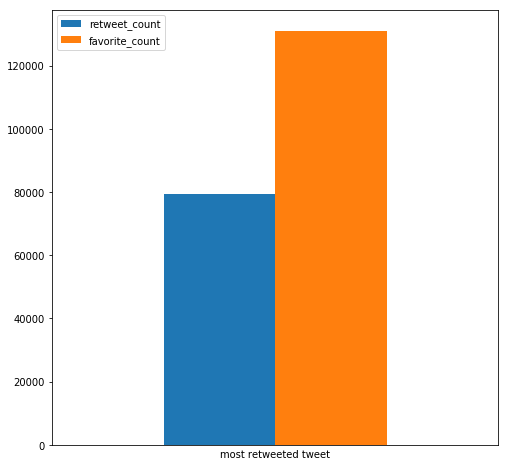

In [541]:
tweets_df.query('retweet_count == retweet_count.max()')[['retweet_count','favorite_count']].plot.bar(figsize = (8,8))
plt.xlabel('most retweeted tweet')
plt.xticks([])
plt.show()

### 2- What was the dog species prediction for the tweet with highest retweets?

In [542]:
predictions_df.query('tweet_id == "744234799360020481"').iloc[0,3:4].values

array(['Labrador_retriever'], dtype=object)

### 3- Which tweet had the most likes?

In [543]:
tweets_df.query('favorite_count == favorite_count.max()')

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
306,822872901745569793,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,13.0,10.0,NaN,puppo,48265,132810


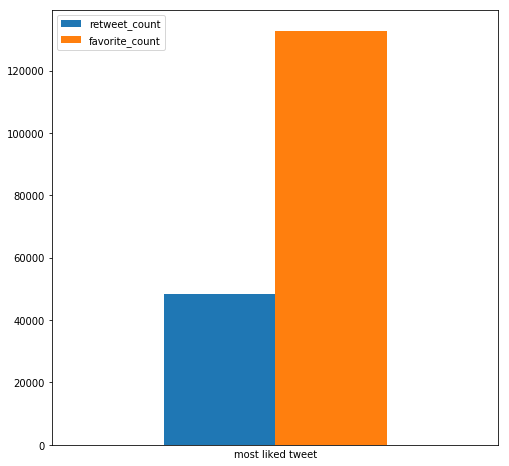

In [544]:
tweets_df.query('favorite_count == favorite_count.max()')[['retweet_count','favorite_count']].plot.bar(figsize = (8,8))
plt.xlabel('most liked tweet')
plt.xticks([])
plt.show()

### 4- What was the dog species prediction for the tweet with most likes?

In [545]:
predictions_df.query('tweet_id == "822872901745569793"').iloc[0,3:4].values

array(['Lakeland_terrier'], dtype=object)

### 5- Which dog species were the top 5 predictions.

#### 1st prediction attempt top 3:

In [546]:
predictions_df[predictions_df['attempt'] == '1'].prediction.value_counts()[:3]

Golden_retriever      137
Labrador_retriever     94
Pembroke               88
Name: prediction, dtype: int64

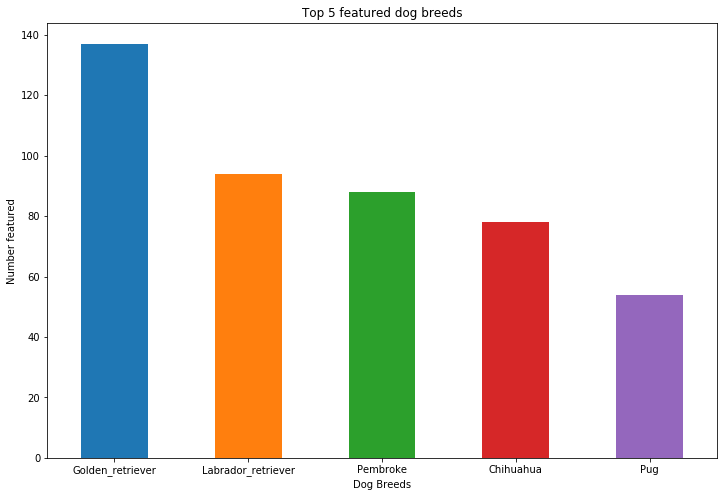

In [547]:
predictions_df[predictions_df['attempt'] == '1'].prediction.value_counts()[:5].plot.bar(figsize=(12,8))
plt.xticks(rotation=360)
plt.xlabel('Dog Breeds')
plt.ylabel('Number featured')
plt.title('Top 5 featured dog breeds')
plt.show()

#### 2nd prediction attempt top 3:

In [548]:
predictions_df[predictions_df['attempt'] == '2'].prediction.value_counts()[:3]

Labrador_retriever    95
Golden_retriever      82
Cardigan              73
Name: prediction, dtype: int64

#### 3rd prediction attempt top 3:

In [549]:
predictions_df[predictions_df['attempt'] == '3'].prediction.value_counts()[:3]

Labrador_retriever    76
Chihuahua             57
Golden_retriever      45
Name: prediction, dtype: int64

### 6- Average confidence level for `Golden retriever`, the top predicted breed in 1st prediction attempt.

In [550]:
predictions_df.query('attempt == "1" & prediction in ["Golden_retriever","Labrador_retriever","Pembroke"] ').groupby('prediction')['conf_level'].mean().sort_values(ascending = False)

prediction
Golden_retriever      0.728116
Pembroke              0.717223
Labrador_retriever    0.656606
Name: conf_level, dtype: float64

- Average confidence level of Golden retriever prediction in the 1st attempt was 0.73

### Lets look at the tweeting frequency over time!

In [551]:
tweets_df['month_year'] = tweets_df['timestamp'].dt.to_period('M')

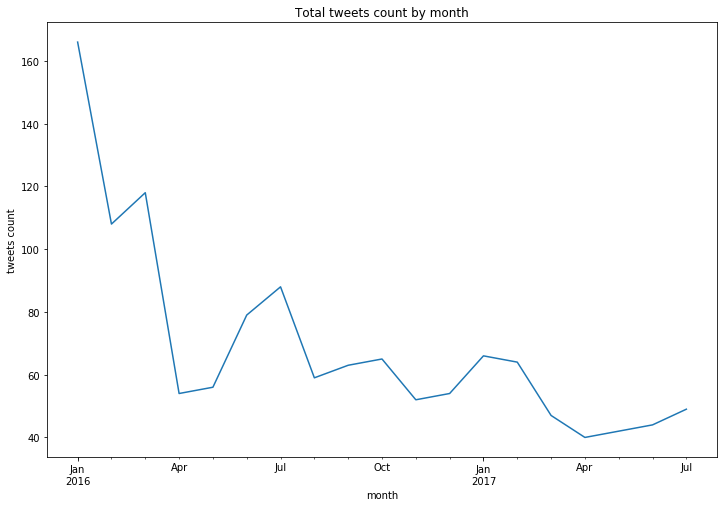

In [552]:
tweets_df.groupby('month_year')['tweet_id'].count()[2:-1].plot.line(figsize=(12,8))
plt.xlabel('month')
plt.ylabel('tweets count')
plt.title('Total tweets count by month')
plt.show()

### 7- What is the trend in retweets over time?

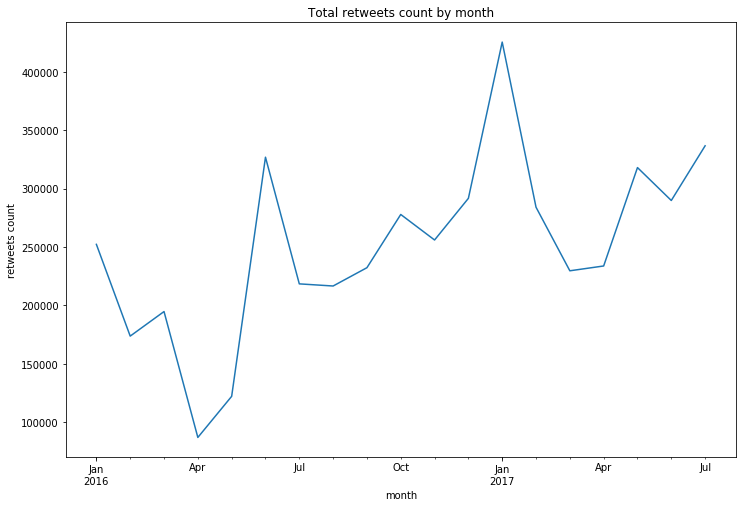

In [553]:
tweets_df.groupby('month_year')['retweet_count'].sum()[2:-1].plot.line(figsize=(12,8))
plt.xlabel('month')
plt.ylabel('retweets count')
plt.title('Total retweets count by month')
plt.show()

``WeRateDogs`` tweets has seen an **upward** trend in **retweets** count since the **second half of 2016**

- Good sign showing increasing interest in their content, people seem to really like dogs!

### 8- What is the trend in likes over time?

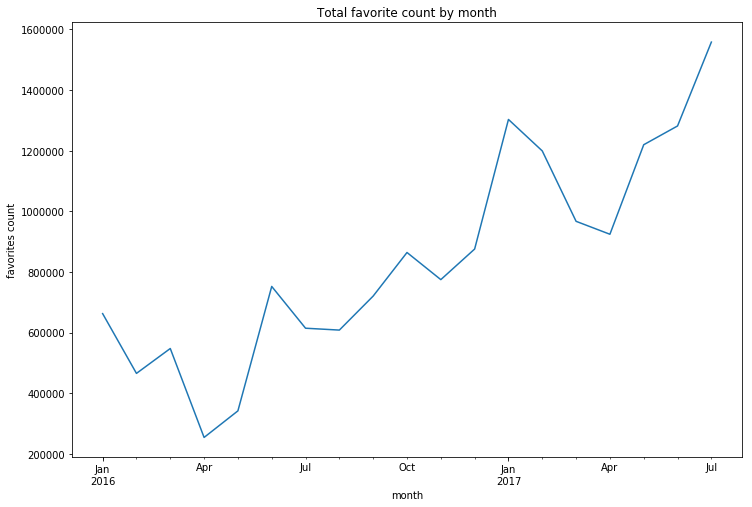

In [554]:
tweets_df.groupby('month_year')['favorite_count'].sum()[2:-1].plot.line(figsize=(12,8))
plt.xlabel('month')
plt.ylabel('favorites count')
plt.title('Total favorite count by month')
plt.show()

``WeRateDogs`` tweets has seen an **upward** trend in **favorites/likes** count since the **second half of 2016**

- A positive trend in favorites/likes count is also a good sign of growing audience.

### 9- Correlation between dog ratings and retweets & favorites count.

In [555]:
tweets_df['overall_rating'] = tweets_df.rating_numerator / tweets_df.rating_denominator

In [556]:
tweets_df.head(1)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,month_year,overall_rating
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,8853,39467,2017-08,1.3


In [557]:
average_ratings_no_outliers = tweets_df.query('rating_numerator < 15').overall_rating.mean()
average_ratings_no_outliers

1.053237497676148

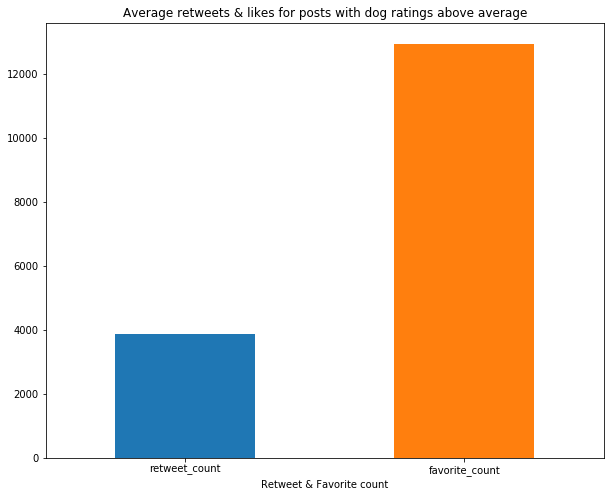

In [558]:
tweets_df.query('overall_rating > 1.05')[['retweet_count','favorite_count']].mean().plot.bar(figsize=(10,8))
plt.title('Average retweets & likes for posts with dog ratings above average')
plt.xlabel('Retweet & Favorite count')
plt.xticks(rotation = 360)
plt.show()

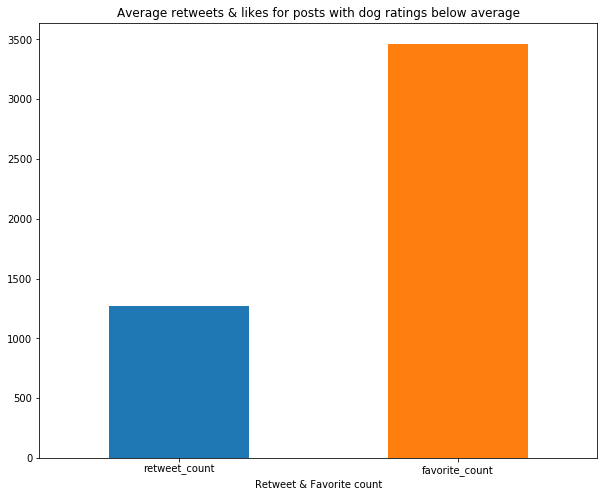

In [559]:
tweets_df.query('overall_rating < 1.05')[['retweet_count','favorite_count']].mean().plot.bar(figsize=(10,8))
plt.title('Average retweets & likes for posts with dog ratings below average')
plt.xlabel('Retweet & Favorite count')
plt.xticks(rotation = 360)
plt.show()

- Dog ratings are somewhat correlated with the favorites & retweets count. Requires more studying to quantify the impact.

### 10- Correlation between dog stages and retweets & favorites count.

In [560]:
tweets_df.groupby('dog_stage').retweet_count.sum().sort_values(ascending = False)

dog_stage
pupper            478883
doggo             448919
puppo             142427
doggo, pupper      35178
floofer            34781
doggo, puppo       19196
doggo, floofer      3433
Name: retweet_count, dtype: int64

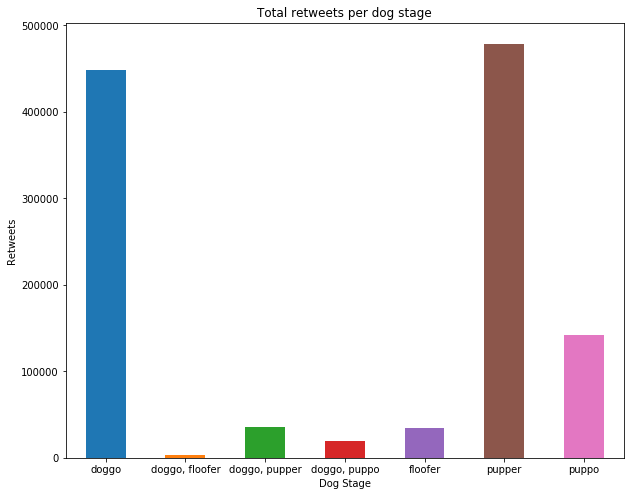

In [561]:
tweets_df.groupby('dog_stage').retweet_count.sum().plot.bar(figsize = (10,8))
plt.title('Total retweets per dog stage')
plt.xlabel('Dog Stage')
plt.ylabel('Retweets')
plt.xticks(rotation = 360)
plt.show()

In [562]:
tweets_df.groupby('dog_stage').favorite_count.sum().sort_values(ascending = False)

dog_stage
pupper            1457356
doggo             1219452
puppo              474806
doggo, pupper      105759
floofer             92442
doggo, puppo        47844
doggo, floofer      17169
Name: favorite_count, dtype: int64

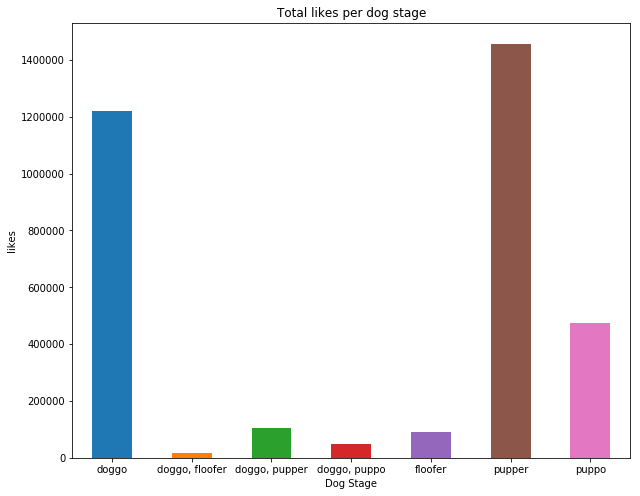

In [563]:
tweets_df.groupby('dog_stage').favorite_count.sum().plot.bar(figsize = (10,8))
plt.title('Total likes per dog stage')
plt.xlabel('Dog Stage')
plt.ylabel('likes')
plt.xticks(rotation = 360)
plt.show()

## Wrangle & Act reports are uploaded in the directory with the names
- wrangle_report.pdf
- act_report.pdf